# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df.Sentiment.unique() #смотрим значения эмоциональных окрасок в категории

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
df1 = df.copy()

map_dict = {'Positive': 1,  'Extremely Positive': 1, 'Negative': 0, 'Extremely Negative': 0}

df1['Sentiment'] = df1['Sentiment'].map(map_dict)
df1.head()
#сайт https://www.dmitrymakarov.ru/data-analysis/encoding-10/?ysclid=lvxkduh0jq521560461#0-pro-kategorialnye-peremennye (это я ещё для себя, на всякий случай)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [ ]:
df1['Sentiment'].value_counts(normalize=True)

Sentiment
1    0.539589
0    0.460411
Name: proportion, dtype: float64

**Ответ:** классы сбалансированы, так как в выборке доли объектов разных классов существенно не различаются.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df1.isna().sum() #по результатам видим, что 7049 пропусков находятся в категории 'Location'

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df1.fillna({'Location': 'Unknown'}, inplace=True) #заполняем пропуски строкой 'Unknown'
df1.isna().sum() #теперь пропусков нет

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size=0.3, random_state=0)

len(train)

23410

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
#пользуемся самой простой токенизацией
#1) Нужно построить словарь на основе обучающей выборки
#2) Нужно посчитать количество встреч каждого токена

#делим текст по пробельным символам и приводим в нижний регистр
lists_tokens = train['OriginalTweet'].apply(lambda x: str(x).lower().split())

list_index = list(lists_tokens.index)

list_with_tokens = []
for i in list_index:
  j=0
  for j in range(len(lists_tokens[i])):
    list_with_tokens.append(lists_tokens[i][j])
    j+=1

dict_token = {}
keys = dict_token.keys()
for k in range(len(list_with_tokens)):
  if list_with_tokens[k] not in keys:
    dict_token[list_with_tokens[k]]=1
  else:
    dict_token[list_with_tokens[k]]+=1

dict_token

{'why': 654,
 'we': 3787,
 'still': 763,
 'want': 487,
 'to': 23373,
 'buy': 748,
 'so': 1837,
 'much': 482,
 'stuff': 106,
 'during': 1908,
 'quarantine': 154,
 'https://t.co/1m881cwfuv': 1,
 '#shopping': 121,
 '#covid_19': 1660,
 '#online': 40,
 'with': 4063,
 'driving': 77,
 'even': 682,
 'more': 2008,
 'usage': 22,
 'a': 11737,
 'strong': 93,
 'strategy': 33,
 'is': 7383,
 'critical': 156,
 'now': 1349,
 'then': 435,
 'ever': 179,
 'luckily': 8,
 'and': 14684,
 'april': 163,
 '16': 36,
 'webinar': 65,
 'will': 2726,
 'dive': 10,
 'into': 666,
 'growing': 84,
 'app': 52,
 'awareness': 32,
 'targeting': 9,
 'high': 408,
 'lifetime': 4,
 'value': 79,
 'users': 19,
 '@canon_india': 16,
 'i': 5340,
 'am': 424,
 'very': 418,
 'happy..': 1,
 'great': 409,
 'job': 242,
 'by': 2236,
 '#canonforcommunity': 5,
 'https://t.co/z0intks34x': 1,
 'the': 26815,
 'u.s': 8,
 'national': 123,
 'debt': 68,
 'likely': 170,
 'exceed': 14,
 '$30': 7,
 'trillion': 21,
 'after': 886,
 'unprecedented': 89,
 

Какой размер словаря получился?

In [ ]:
len(dict_token)

79755

Размер словаря = 79755 токенов.

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
popular_values = (sorted(dict_token.values(), reverse=True))[0:10]

keys = dict_token.keys()
for value in popular_values:
  for key in keys:
    if dict_token[key]==value:
      print(f"Токен '{key}' встречается {value} раз")

Токен 'the' встречается 26815 раз
Токен 'to' встречается 23373 раз
Токен 'and' встречается 14684 раз
Токен 'of' встречается 13012 раз
Токен 'a' встречается 11737 раз
Токен 'in' встречается 11198 раз
Токен 'for' встречается 8566 раз
Токен '#coronavirus' встречается 8223 раз
Токен 'is' встречается 7383 раз
Токен 'are' встречается 7050 раз


**Ответ:** данные токены в топе, потому что они являются составляющими любого предложения (частицы, местоимения, предлоги и тд). Также популярен #coronavirus, так как твиты на тему короны и с того времени.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
keys = dict_token.keys()
for word in stop_words:
  if word in keys:
    dict_token.pop(word)

popular_values = (sorted(dict_token.values(), reverse=True))[0:10]
for value in popular_values:
  for key in keys:
    if dict_token[key]==value:
      print(f"Токен '{key}' встречается '{value}' раз")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Токен '#coronavirus' встречается '8223' раз
Токен 'prices' встречается '3891' раз
Токен 'food' встречается '3820' раз
Токен 'grocery' встречается '3469' раз
Токен 'supermarket' встречается '3288' раз
Токен 'people' встречается '3175' раз
Токен 'covid-19' встречается '3173' раз
Токен 'store' встречается '3155' раз
Токен '#covid19' встречается '2471' раз
Токен '&amp;' встречается '2314' раз


**Ответ:**  теперь здесь нет служебных частей речи. В основном нормальные существительные, но также видим хэштеги и один символ в конце, который, как я понимаю, заменяет союз 'and'.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
unpopular_values = sorted(dict_token.values())[0:20]
keys = dict_token.keys()

counter = 0
for value in unpopular_values:
  for key in keys:
    if dict_token[key] == value:
      print(f"Непопулярный токен {key} встречается {value} раз")
      counter += 1
    elif counter >= 20:
      break

Непопулярный токен https://t.co/1m881cwfuv встречается 1 раз
Непопулярный токен happy.. встречается 1 раз
Непопулярный токен https://t.co/z0intks34x встречается 1 раз
Непопулярный токен mnuchinãâs встречается 1 раз
Непопулярный токен brink. встречается 1 раз
Непопулярный токен https://t.co/jmobv8z0u0 встречается 1 раз
Непопулярный токен university's встречается 1 раз
Непопулярный токен teaching.) встречается 1 раз
Непопулярный токен @catholicpres встречается 1 раз
Непопулярный токен @catholicuniv встречается 1 раз
Непопулярный токен https://t.co/evqby035wf встречается 1 раз
Непопулярный токен https://t.co/riqrhxxeim встречается 1 раз
Непопулярный токен @@ballardspahrll встречается 1 раз
Непопулярный токен #aca встречается 1 раз
Непопулярный токен easier...take встречается 1 раз
Непопулярный токен ãânecessaryãâ встречается 1 раз
Непопулярный токен https://t.co/0fmsmlgepm встречается 1 раз
Непопулярный токен husted: встречается 1 раз
Непопулярный токен irishman встречается 1 раз
Не

**Ответ:** видим много ссылок, указания никнеймов, нормальные слова и хэштеги. Ссылки являются непопулярными, так как это нераспростроненное явление в твитах. Я думаю, что если мы уберём знаки препинания, то можем пополнить словарь нормальными словами, типо из 'happy..' сделаем 'happy' и очевидно сократим словарь, потому что уберём повторы.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

lists_tokens_tw = train['OriginalTweet'].apply(lambda tweet: TweetTokenizer().tokenize(tweet))

list_index_tw = lists_tokens_tw.index

list_with_tokens_tw = []
for ind in list_index_tw:
  j = 0
  for j in range(len(lists_tokens_tw[ind])):
    list_with_tokens_tw.append(lists_tokens_tw[ind][j])
    j += 1

dict_token_tw = {}
keys = dict_token_tw.keys()
for k in range(len(list_with_tokens_tw)):
  if list_with_tokens_tw[k] not in keys:
    dict_token_tw[list_with_tokens_tw[k]]=1
  else:
    dict_token_tw[list_with_tokens_tw[k]]+=1

popular_values_tw = (sorted(dict_token_tw.values(), reverse=True))[0:10]

keys_tw = dict_token_tw.keys()
for value in popular_values_tw:
  for key in keys_tw:
    if dict_token_tw[key] == value:
      print(f"Токен '{key}' встречается {value} раз")

Токен 'the' встречается 24337 раз
Токен '.' встречается 24118 раз
Токен 'to' встречается 22933 раз
Токен ',' встречается 17571 раз
Токен 'and' встречается 14354 раз
Токен 'of' встречается 12904 раз
Токен 'a' встречается 11045 раз
Токен 'in' встречается 10573 раз
Токен '?' встречается 9524 раз
Токен 'for' встречается 8228 раз


**Ответ:** здесь как отдельные токены появились знаки препинания, потому что мы применили более точно разделяющую токенизацию.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

stop_words = stopwords.words('english')
keys_tw = dict_token_tw.keys()
for word in stop_words:
  if word in keys_tw:
    dict_token_tw.pop(word)

for punct in punctuation:
  if punct in keys:
    dict_token_tw.pop(punct)

popular_values_tw = (sorted(dict_token_tw.values(), reverse=True))[0:10]
for value in popular_values_tw:
  for key in keys_tw:
    if dict_token_tw[key] == value:
      print(f"Токен '{key}' встречается '{value}'")

Токен 'Â' встречается '7415'
Токен '' встречается '7311'
Токен '19' встречается '7167'
Токен '#coronavirus' встречается '7143'
Токен 'I' встречается '5235'
Токен '' встречается '4372'
Токен 'prices' встречается '4281'
Токен 'COVID' встречается '4218'
Токен 'food' встречается '3795'
Токен 'store' встречается '3691'


**Ответ:** на слова не похожи символы в виде прямоугольников, возможно, это смайлики. Также появилась цифра 19.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
keys_tw = dict_token_tw.keys()
dict_token_tw_2 = dict_token_tw.copy()
for key in keys_tw:
  if (len(key) == 1 and ord(key) >= 128) or len(key) == 1:
    dict_token_tw_2.pop(key)

popular_values_tw = (sorted(dict_token_tw_2.values(), reverse=True))[0:10]
keys_tw_2 = dict_token_tw_2.keys()
for value in popular_values_tw:
  for key in keys_tw_2:
    if dict_token_tw_2[key] == value:
      print(f"Токен '{key}' встречается '{value}' раз")

unpopular_values_tw = sorted(dict_token_tw_2.values())[0:20]
counter = 0
for value in unpopular_values:
  for key in keys_tw_2:
    if dict_token_tw_2[key] == value:
      print(f"Непопулярный токен {key} встречается {value} раз")
      counter += 1
    elif counter >= 20:
      break

Токен '19' встречается '7167' раз
Токен '#coronavirus' встречается '7143' раз
Токен 'prices' встречается '4281' раз
Токен 'COVID' встречается '4218' раз
Токен 'food' встречается '3795' раз
Токен 'store' встречается '3691' раз
Токен 'supermarket' встречается '3373' раз
Токен 'grocery' встречается '3083' раз
Токен 'people' встречается '3047' раз
Токен 'The' встречается '2516' раз
Непопулярный токен https://t.co/1m881CwFUv встречается 1 раз
Непопулярный токен https://t.co/Z0intkS34x встречается 1 раз
Непопулярный токен MnuchinÃ встречается 1 раз
Непопулярный токен https://t.co/JmoBv8z0U0 встречается 1 раз
Непопулярный токен University's встречается 1 раз
Непопулярный токен @CatholicPres встречается 1 раз
Непопулярный токен @CatholicUniv встречается 1 раз
Непопулярный токен https://t.co/EvQby035wF встречается 1 раз
Непопулярный токен https://t.co/rIQrhxxeIM встречается 1 раз
Непопулярный токен @BallardSpahrLL встречается 1 раз
Непопулярный токен #training встречается 1 раз
Непопулярный ток

**Ответ:** здесь как отдельный токен есть цифра '19' и 'COVID', что означает, что, благодаря более точному разделению, были устранены повторы, тем самым, скорее всего, и размер словаря уменьшился. В непопулярных стало больше ссылок, хэштегов. Токенизация провела более умное разделение.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
keys_tw_2 = dict_token_tw_2.keys()
hashtag = {}
for key in keys_tw_2:
  if '#' in key[0]:
    hashtag[key] = dict_token_tw_2[key]

popular_v_hashtag = (sorted(hashtag.values(), reverse=True))[0:10]
keys_hash = hashtag.keys()
for value in popular_v_hashtag:
  for key in keys_hash:
    if hashtag[key] == value:
      print(f"Хештег '{key}' встречается '{value}' раз")

Хештег '#coronavirus' встречается '7143' раз
Хештег '#COVID19' встречается '1844' раз
Хештег '#Covid_19' встречается '1463' раз
Хештег '#Coronavirus' встречается '1281' раз
Хештег '#COVID2019' встречается '927' раз
Хештег '#toiletpaper' встречается '657' раз
Хештег '#covid19' встречается '568' раз
Хештег '#COVID' встречается '542' раз
Хештег '#CoronaCrisis' встречается '426' раз
Хештег '#CoronaVirus' встречается '351' раз


**Ответ:** все хештеги посвящены теме коронавируса или как-то связаны с ней, например, "#toiletpaper" 😀

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
keys_tw_2 = dict_token_tw_2.keys()
links = {}
for key in keys_tw_2:
  if 'https://t.co' in key:
    links[key] = dict_token_tw_2[key]

counter = 0
popular_v_links = (sorted(links.values(), reverse=True))[0:10]
keys_link = links.keys()
for value in popular_v_links:
  for key in keys_link:
    if links[key] == value:
      print(f"Сайт '{key}' встречается '{value}' раз")
      counter += 1
    if counter >= 10:
      break

Сайт 'https://t.co/oXA7SWtoNd' встречается '5' раз
Сайт 'https://t.co/gP3EusapL8' встречается '4' раз
Сайт 'https://t.co/DefTruI1PfÃÂ' встречается '3' раз
Сайт 'https://t.co/WrLHYzIzAA' встречается '3' раз
Сайт 'https://t.co/kuwIpF1KQW' встречается '3' раз
Сайт 'https://t.co/zjNRx6dKKN' встречается '3' раз
Сайт 'https://t.co/3GBBDpdjat' встречается '3' раз
Сайт 'https://t.co/e2ZNXajPre' встречается '3' раз
Сайт 'https://t.co/CATKegAyOY' встречается '3' раз
Сайт 'https://t.co/G63RP042HO' встречается '3' раз


**Ответ:** популярность ссылок не сравнима с популярностью хештегов, ссылки более чем в 1000 раз менее популярны. Не всегда информация о ссылке полезна, иногда можно нарваться на вирус, как пример :-)

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text_lower = text.lower()

  tokens = set(TweetTokenizer().tokenize(text_lower))

  stop_words_2 = stopwords.words('english')
  for word in stop_words_2:
    if word in tokens:
      tokens.discard(word)

  for punct in punctuation:
    if punct in tokens:
      tokens.discard(punct)

  for token in list(tokens):
    if (len(token) == 1 and ord(token) >= 128) or (token[0:12] == 'https://t.co'):
      tokens.discard(token)

  return list(tokens)

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['text', '#sampletext', 'sample', '@sample_text']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
tokens_cv = cv.fit_transform(train['OriginalTweet'])


print(len(cv.vocabulary_))

45308


**Ответ:** он приблизительно в 2 раза меньше.

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
tweet = (train.iloc[ind]['OriginalTweet']).split()

tweet_cv = cv.fit_transform(train['OriginalTweet'])

vec = pd.DataFrame(data = tweet_cv.toarray(), columns = cv.get_feature_names_out(tweet)).iloc[[ind]]
vec = vec.drop(columns = vec.columns[vec.iloc[0] == 0])
vec

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
9023,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** видим, что максимальная компонента в векторе у каждого токена - '1', значит, определить важный и неважный токен не получится.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer = custom_tokenizer)

t_v_train = tv.fit_transform(train['OriginalTweet'])

vec_1 = pd.DataFrame(data=t_v_train.toarray(), columns=tv.get_feature_names_out()).iloc[[ind]]
vec_1 = vec_1.drop(columns=vec_1.columns[vec_1.iloc[0] == 0])
vec_1

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
9023,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


In [ ]:
#токен с самым большим весом
print(vec_1.idxmax(axis = 1))
print(vec_1.max(axis = 1))

9023    brainless
dtype: object
9023    0.386764
dtype: float64


In [ ]:
#токен с самым маленьким весом
print(vec_1.idxmin(axis = 1))
print(vec_1.min(axis = 1))

9023    food
dtype: object
9023    0.113289
dtype: float64


**Ответ:** важный токен - 'brainless', так как он имеет наибольший вес среди других токенов; неважный токен - 'food', так как он имеет наименьший вес среди других токенов.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'doctor' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
7798,13276,58228,NY,20-03-2020,"Please don't claim to support all the doctors,...",1
23623,32655,77607,"Kerala, India",05-04-2020,"I've just posted a new blog: After recovery, O...",1
15578,22743,67695,"ÃÂT: 33.143271,-117.107195",24-03-2020,In the spirit of Animal Crossing crafting and ...,1
12781,19294,64246,"Hallandale Beach, FL",22-03-2020,"We should be thankful to our first responders,...",1
18673,26532,71484,Unknown,25-03-2020,"Thank you doctors, nurses, health care helpers...",1
...,...,...,...,...,...,...
23836,32933,77885,"New York, NY",05-04-2020,LetÃÂs thank the #supermarket #store #restau...,1
20177,28401,73353,everywhere,26-03-2020,We canÃÂt thank them enough!! #nhs #nurses #...,1
24729,34063,79015,United States of America,06-04-2020,@Acosta ThatÃÂs very telling. Also telling i...,1
22302,31046,75998,"North Miami Beach, Florida",03-04-2020,ÃÂAn apple a day keeps the doctor away.ÃÂ ...,1


In [ ]:
ind_1 = 18673

vec_2 = pd.DataFrame(t_v_train.toarray(), columns=tv.get_feature_names_out()).loc[[ind_1]]
vec_2 = vec_2.drop(columns=vec_2.columns[vec_2.iloc[0] == 0])
vec_2

,12,followers,important,interview,listen,mins,please,rt,time
18673,0.323407,0.422877,0.274167,0.374503,0.334468,0.430122,0.207359,0.351034,0.195106


In [ ]:
train.iloc[ind_1]['OriginalTweet']

"Can I have 12 mins of your time to PLEASE LISTEN to this interview as IT'S SO IMPORTANT can my followers RT. https://t.co/7FDqsKedFP"

In [ ]:
#токен с самым большим весом
print(vec_2.idxmax(axis = 1))
print(vec_2.max(axis = 1))

18673    mins
dtype: object
18673    0.430122
dtype: float64


**Ответ:**  В ОБЩЕМ Я ИСКРЕННЕ НЕ ПОНИМАЮ, ПОЧЕМУ МНЕ НЕ ВЫВОДИТСЯ ТВИТ, КОТОРЫЙ Я ХОЧУ, ВОЗМОЖНО, У МЕНЯ ЗАМЫЛИЛСЯ ГЛАЗ И Я НЕ ВИЖУ ОШИБКУ В КОДЕ. НО ИДЕЯ БЫЛА В ТОМ, ЧТО ПРО ДОКТОРОВ ГОВОРЯТ ТОЛЬКО ХОРОШЕЕ!

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
X_train = train.loc[:, train.columns != 'Sentiment']
y_train = train['Sentiment']

X_test = test.loc[:, test.columns != 'Sentiment']
y_test = test['Sentiment']

#применяем CountVectorizer
X_train_cv = cv.fit_transform(X_train['OriginalTweet'])
X_test_cv = cv.transform(X_test['OriginalTweet'])

#применяем TfidfVectorizer
X_train_tv = tv.fit_transform(X_train['OriginalTweet'])
X_test_tv = tv.transform(X_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()

#обучаем логистическую регрессию на векторах из CountVectorizer
log_reg.fit(X_train_cv, y_train)
y_train_pred_cv = log_reg.predict(X_train_cv)
y_test_pred_cv = log_reg.predict(X_test_cv)
print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_cv)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_cv)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.9830841520717643
Доля правильных ответов (accuracy) на тестовых данных = 0.866155072752641


In [ ]:
#обучаем лог. регрессию на векторах из TfidfVectorizer
log_reg.fit(X_train_tv, y_train)
y_train_pred_tv = log_reg.predict(X_train_tv)
y_test_pred_tv = log_reg.predict(X_test_tv)
print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_tv)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_tv)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.924647586501495
Доля правильных ответов (accuracy) на тестовых данных = 0.85280047837353


**Ответ:** векторайзер CountVectorizer (cv) имеет долю правильных ответов выше, чем TfidfVectorizer (tv). Отмечу, что в случае с cv accuracy на train стремиится к 1 и разница между accuracy на train и test больше, чем в случае с tv, что может говорить о переобучении 1 модели с cv.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  text_lower = text.lower()

  tokens = set(TweetTokenizer().tokenize(text_lower))

  stop_words_2 = stopwords.words('english')
  for word in stop_words_2:
    if word in tokens:
      tokens.discard(word)

  for punct in punctuation:
    if punct in tokens:
      tokens.discard(punct)

  for token in list(tokens):
    if (len(token) == 1 and ord(token) >= 128) or (token[0:12] == 'https://t.co'):
      tokens.discard(token)

  tokens = list(tokens)

  #добавляем стемминг
  stemmer = SnowballStemmer('english')
  tokens_2 = []
  for word in tokens:
    tokens_2.append(stemmer.stem(word))

  return tokens_2

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['text', '#sampletext', 'sampl', 'word', '@sample_text', 'ad', 'stem', 'check']

In [ ]:
#обучаю CountVectorizer
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
ot_cv = cv.fit_transform(train['OriginalTweet'])
print(len(cv.vocabulary_))

36652


In [ ]:
#обучаю TfidfVectorizer
tv = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
ot_tv = tv.fit_transform(train['OriginalTweet'])

**Ответ:** словарь уменьшился примерно на 20% по сравнению с последним.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
#применяем CountVectorizer
X_train_cv = cv.fit_transform(X_train['OriginalTweet'])
X_test_cv = cv.transform(X_test['OriginalTweet'])

#обучаю лог. регрессию с использованием CountVectorizer
log_reg.fit(X_train_cv, y_train)
y_train_pred_cv = log_reg.predict(X_train_cv)
y_test_pred_cv = log_reg.predict(X_test_cv)
print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_cv)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_cv)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.9692439128577531
Доля правильных ответов (accuracy) на тестовых данных = 0.8666533785130556


In [ ]:
#применяем TfidfVectorizer
X_train_tv = tv.fit_transform(X_train['OriginalTweet'])
X_test_tv = tv.transform(X_test['OriginalTweet'])

#обучаем лог. регрессию на векторах из TfidfVectorizer
log_reg.fit(X_train_tv, y_train)
y_train_pred_tv = log_reg.predict(X_train_tv)
y_test_pred_tv = log_reg.predict(X_test_tv)
print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_tv)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_tv)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.9156770610850065
Доля правильных ответов (accuracy) на тестовых данных = 0.8567869244568467


**Ответ:** качество стало чуть хуже на обучающих данных и оно чуть выше стало на тестовых. В прицнипе такое мизирное изменение не дало супер эффективности, поэтому, скорее всего, нет смысла применять стемминг.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36651


In [ ]:
X_train_cv_max = cv_df.fit_transform(X_train['OriginalTweet'])
X_test_cv_max = cv_df.transform(X_test['OriginalTweet'])

log_reg.fit(X_train_cv_max, y_train)

y_train_pred_cv_max = log_reg.predict(X_train_cv_max)
y_test_pred_cv_max = log_reg.predict(X_test_cv_max)

print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_cv_max)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_cv_max)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.9694147800085433
Доля правильных ответов (accuracy) на тестовых данных = 0.866155072752641


**Ответ:** относительно размера словаря max_df небольшой. Accuracy на train увеличилось на 0.002, accuracy на test уменьшилось на 0.005.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
X_train_cv_min = cv_df.fit_transform(X_train['OriginalTweet'])
X_test_cv_min = cv_df.transform(X_test['OriginalTweet'])

log_reg.fit(X_train_cv_min, y_train)

y_train_pred_cv_min = log_reg.predict(X_train_cv_min)
y_test_pred_cv_min = log_reg.predict(X_test_cv_min)

print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_cv_min)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_cv_min)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.9260999572832123
Доля правильных ответов (accuracy) на тестовых данных = 0.8650588000797289


**Ответ:** accuracy на train уменьшилось; accuracy на test тоже уменьшилось, но не очень сильно.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

train_delete = pd.DataFrame(X_train_cv_min.toarray(), columns = cv_df.get_feature_names_out())
test_delete = pd.DataFrame(X_test_cv_min.toarray(), columns = cv_df.get_feature_names_out())

X_train_cv_min_stand = scaler.fit_transform(train_delete)
X_test_cv_min_stand = scaler.transform(test_delete)

log_reg.fit(X_train_cv_min_stand, y_train)

y_train_pred_stand = log_reg.predict(X_train_cv_min_stand)
y_test_pred_stand = log_reg.predict(X_test_cv_min_stand)

print(f"Доля правильных ответов (accuracy) на обучающих данных = {accuracy_score(y_train, y_train_pred_stand)}")
print(f"Доля правильных ответов (accuracy) на тестовых данных = {accuracy_score(y_test, y_test_pred_stand)}")

Доля правильных ответов (accuracy) на обучающих данных = 0.9396411789833404
Доля правильных ответов (accuracy) на тестовых данных = 0.8424357185569065


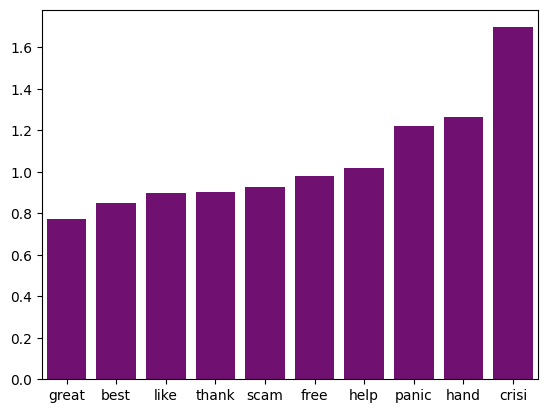

In [ ]:
weights = abs(log_reg.coef_[0])
feature_names = cv_df.get_feature_names_out()
top_weights = np.sort(weights)[-10:]
top_weights_index = np.argsort(weights)[-10:]
top_weights_name = [feature_names[name] for name in top_weights_index]

sns.barplot(y=top_weights, x = top_weights_name, color = 'purple');

**Ответ:** наибольший вес имеет токен 'crisi', который видимо из-за стемминга был сокращён. Он является самым важным. Наименьший вес имеет токен 'great', который является наименее важным токеном. Прочитав, все токены понимаем, что по ним можно определить окрас твита (положительный/негативный).

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
max(train['UserName'].value_counts())

1

In [ ]:
max(train['ScreenName'].value_counts())

1

In [ ]:
train['UserName']

25621    35178
30135    40819
28899    39249
5989     11068
4367      9109
         ...  
20757    29120
32103    43291
30403    41159
21243    29702
2732      7104
Name: UserName, Length: 23410, dtype: int64

In [ ]:
train['ScreenName']

25621    80130
30135    85771
28899    84201
5989     56020
4367     54061
         ...  
20757    74072
32103    88243
30403    86111
21243    74654
2732     52056
Name: ScreenName, Length: 23410, dtype: int64

**Ответ:** видим, что у UserName и ScreenName уникальные значения, состоящие из цифр, что никакой полезности при анализе не принесёт. С данными признаками нам делать нечего :-(

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
#преобразование признакак TweetAt к типу datetime
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
train['TweetAt']

25621   2020-04-06
30135   2020-04-10
28899   2020-04-09
5989    2020-03-19
4367    2020-03-18
           ...    
20757   2020-03-31
32103   2020-04-13
30403   2020-04-10
21243   2020-04-01
2732    2020-03-18
Name: TweetAt, Length: 23410, dtype: datetime64[ns]

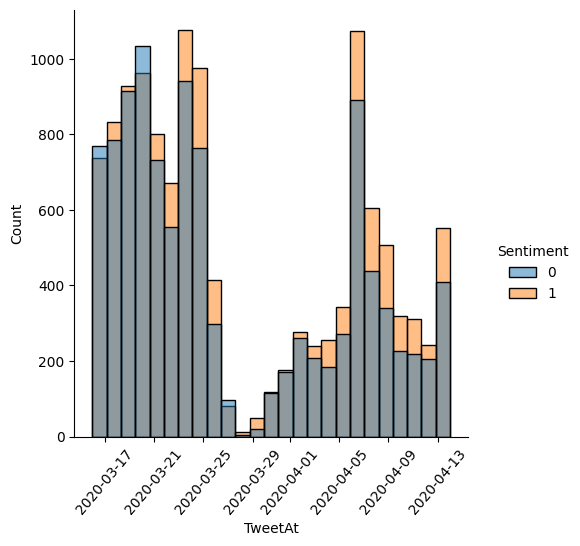

In [ ]:
sns.displot(train, x='TweetAt', hue='Sentiment')
plt.xticks(rotation=50);

**Ответ:** видим, что большинство твитов с положительным окрасом, только в три даты мы наблюдаем большинство негативных твитов. Так как большинство твитов с положительным окрасом, нам нет пользы анализировать данный признак.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
len(train['Location'].unique())

7949

7949 уникальных значений

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

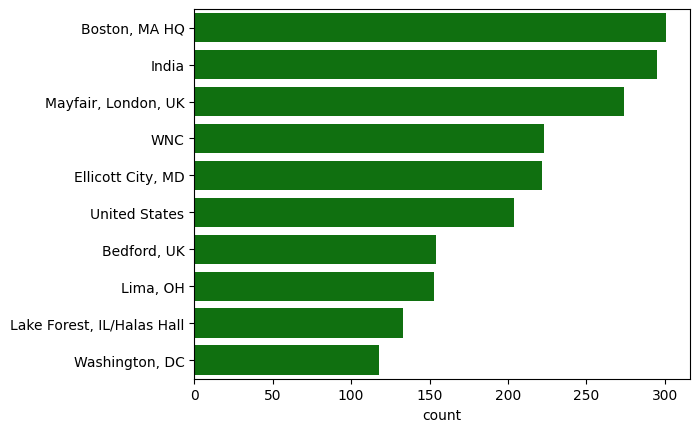

In [ ]:
location_without_unknown= train[train['Location'] != 'Unknown']
location_unique = location_without_unknown['Location'].unique()
location_value = location_without_unknown['Location'].value_counts()
sns.barplot(y=location_unique[:10], x = location_value[:10], color='green');